# Gradient-based optimization of fluid flows

<div class="admonition note alert alert-warning">
<p class="admonition-title">Note</p>

All examples are expected to run from the `examples/<example_name>` directory of the [Tesseract-JAX repository](https://github.com/pasteurlabs/tesseract-jax).
</div>

In this example, you will learn how to:
1. Build a Tesseract that wraps a differentiable simulator from [JAX-CFD](https://github.com/google/jax-cfd).
1. Access its endpoints via Tesseract-JAX's `apply_tesseract()` function.
2. Perform gradient-based optimization of the fluid simulation (via `scipy.optimize.minimize`), using the Tesseract as a differentiable simulator.


The goal of this application is to find initial conditions for which the final fluid flow is close to this image (the [Pasteur Labs](https://pasteurlabs.ai) logo):

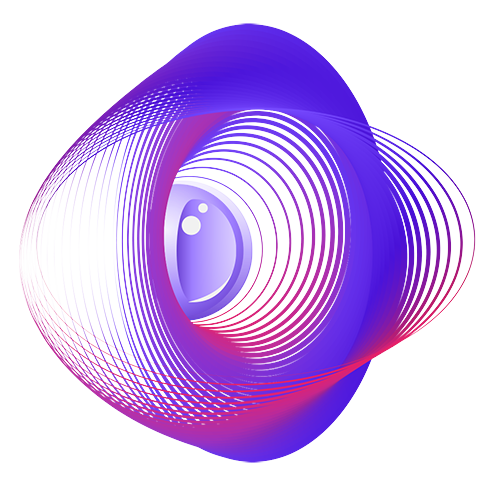

In [1]:
from IPython.display import HTML, Image

Image(filename="pl.png", width=200)

In [2]:
# Install additional requirements
%pip install -r requirements.txt -q


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 1: Build + serve JAX-CFD Tesseract

`cfd-tesseract` is a differentiable Navier-Stokes solver based on [JAX-CFD](https://github.com/google/jax-cfd) that is wrapped in a Tesseract.

Here is its `apply` function, as defined in `cfd_tesseract/tesseract_api.py`:

```python
def cfd_fwd(
    v0: jnp.ndarray,
    density: float,
    viscosity: float,
    inner_steps: int,
    outer_steps: int,
    max_velocity: float,
    cfl_safety_factor: float,
    domain_size_x: float,
    domain_size_y: float,
) -> tuple[jax.Array, jax.Array]:
    """Compute the final velocity field using the semi-implicit Navier-Stokes equations.

    Args:
        v0: Initial velocity field.
        density: Density of the fluid.
        viscosity: Viscosity of the fluid.
        inner_steps: Number of solver steps for each timestep.
        outer_steps: Number of timesteps steps.
        max_velocity: Maximum velocity.
        cfl_safety_factor: CFL safety factor.
        domain_size_x: Domain size in x direction.
        domain_size_y: Domain size in y direction.

    Returns:
        Final velocity field.
    """
    vx0 = v0[..., 0]
    vy0 = v0[..., 1]
    bc = cfd.boundaries.HomogeneousBoundaryConditions(
        (
            (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
            (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
        )
    )

    # reconstruct grid from input
    grid = cfd.grids.Grid(
        vx0.shape, domain=((0.0, domain_size_x), (0.0, domain_size_y))
    )

    vx0 = cfd.grids.GridArray(vx0, grid=grid, offset=(1.0, 0.5))
    vy0 = cfd.grids.GridArray(vy0, grid=grid, offset=(0.5, 1.0))

    # reconstruct GridVariable from input
    vx0 = cfd.grids.GridVariable(vx0, bc)
    vy0 = cfd.grids.GridVariable(vy0, bc)
    v0 = (vx0, vy0)

    # Choose a time step.
    dt = cfd.equations.stable_time_step(
        max_velocity, cfl_safety_factor, viscosity, grid
    )

    # Define a step function and use it to compute a trajectory.
    step_fn = cfd.funcutils.repeated(
        cfd.equations.semi_implicit_navier_stokes(
            density=density, viscosity=viscosity, dt=dt, grid=grid
        ),
        steps=inner_steps,
    )
    rollout_fn = cfd.funcutils.trajectory(step_fn, outer_steps)
    _, trajectory = jax.device_get(rollout_fn(v0))
    vxn = trajectory[0].array.data[-1]
    vyn = trajectory[1].array.data[-1]
    return jnp.stack([vxn, vyn], axis=-1)
```

To build the Tesseract, we use the `tesseract` command line tool.

In [3]:
%%bash
# Build CFD Tesseract so we can use it below
tesseract build cfd-tesseract/

 [i] Building image ...
⠴ Processing
 [i] Built image sha256:53c58414f0aa, ['jax-cfd:latest']


["jax-cfd:latest"]


To interact with the Tesseract, we use the Python SDK from `tesseract_core` to load the built image and start a server container.

In [4]:
from tesseract_core import Tesseract

cfd_tesseract = Tesseract.from_image("jax-cfd")
cfd_tesseract.serve()

## Step 2: Test forward evaluation with Tesseract-JAX

Let's set up the Tesseract with Tesseract-JAX and test a simple forward evaluation. First, we'll define an initial guess for the velocity field over a grid. The resulting `vx` and `vy` give our horizontal and vertical velocity fields, respectively.

In [5]:
# Import necessary libraries
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from scipy.optimize import minimize
from tqdm import tqdm

from tesseract_jax import apply_tesseract

# Set up the CFD simulation parameters
seed = 0
size = 64
max_velocity = 3.0
domain_size_x = jnp.pi * 2
domain_size_y = jnp.pi * 2

bc = cfd.boundaries.HomogeneousBoundaryConditions(
    (
        (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
        (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
    )
)

grid = cfd.grids.Grid((size, size), domain=((0, domain_size_x), (0, domain_size_y)))
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity
)
vx, vy = v0

params = {
    "density": 1.0,
    "viscosity": 0.01,
    "inner_steps": 25,
    "outer_steps": 30,
    "max_velocity": max_velocity,
    "cfl_safety_factor": 0.5,
    "domain_size_x": domain_size_x,
    "domain_size_y": domain_size_y,
}

# Define initial velocity field
v0 = np.stack([np.array(vx.array.data), np.array(vy.array.data)], axis=-1)


# Define the Tesseract function
def cfd_tesseract_fn(v0):
    return apply_tesseract(cfd_tesseract, inputs=dict(v0=v0, **params))


# Apply Tesseract to the initial velocity field
outputs = cfd_tesseract_fn(v0)

Using the results of the forward pass, we can set up a basic approach for visualising our velocity field.
We'll use `matplotlib` to show the $x$ and $y$ components of the velocity as heatmaps.

Text(0.5, 1.0, 'vy')

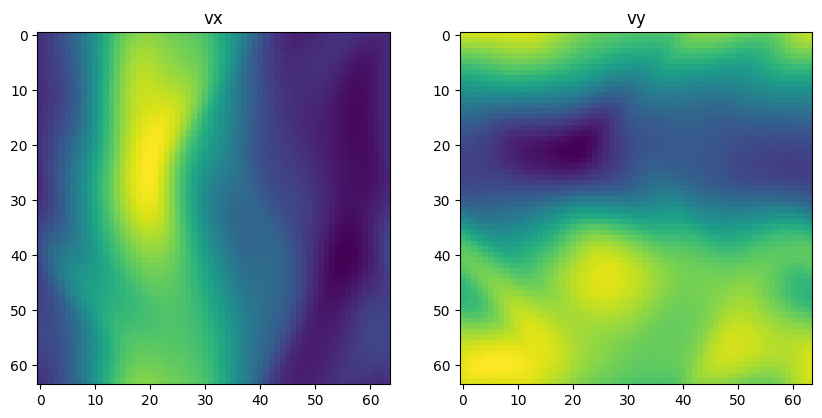

In [6]:
vxn = outputs["result"][..., 0]
vyn = outputs["result"][..., 1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(vxn, cmap="viridis")
ax[0].set_title("vx")
ax[1].imshow(vyn, cmap="viridis")
ax[1].set_title("vy")

Next we define a vorticity function for later use (recalling that vorticity is the curl of the flow velocity, *ie.* $\omega = \nabla \times \mathbf{v}$).

In [7]:
def vorticity(vxn, vyn):
    vxn = cfd.grids.GridArray(vxn, grid=grid, offset=(1.0, 0.5))
    vyn = cfd.grids.GridArray(vyn, grid=grid, offset=(0.5, 1.0))

    # reconstrut GridVariable from input
    vxn = cfd.grids.GridVariable(vxn, bc)
    vyn = cfd.grids.GridVariable(vyn, bc)

    # differntiate
    _, dvx_dy = cfd.finite_differences.central_difference(vxn)
    dvy_dx, _ = cfd.finite_differences.central_difference(vyn)

    return dvy_dx.data - dvx_dy.data

## Step 3: Optimize the initial state so the fluid evolves into the Pasteur Labs logo

Now we want to perform an actual optimization.
Our goal is to find an initial state $v_0$, such that the vorticity of the final state $v_N$ resembles the Pasteur Labs logo.

Let's start by loading in our logo.

Text(0.5, 1.0, 'Target vorticity')

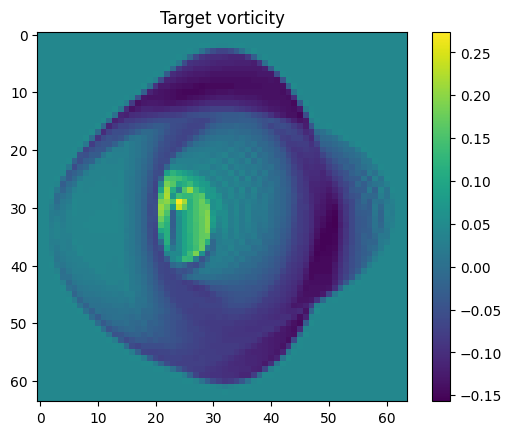

In [8]:
img = plt.imread("pl.png")
img = img.mean(axis=-1)
img = PILImage.fromarray((img * 255).astype(np.uint8))
img_shape_y, img_shape_x = img.size

img = img.resize((size, size))
img = np.array(img).astype(np.float32) / 255.0

# normalize around 0
img = img - img.mean()

plt.imshow(img, cmap="viridis")
plt.colorbar()
plt.title("Target vorticity")

We define the loss function, which additionally ensures physical realism of the initial condition by penalizing the flow's divergence (incompressibility).

In [9]:
def mse(x, y):
    return jnp.mean((x - y) ** 2)


def divergence(vxn, vyn):
    vxn = cfd.grids.GridArray(vxn, grid=grid, offset=(1.0, 0.5))
    vyn = cfd.grids.GridArray(vyn, grid=grid, offset=(0.5, 1.0))

    # reconstruct GridVariable from input
    vxn = cfd.grids.GridVariable(vxn, bc)
    vyn = cfd.grids.GridVariable(vyn, bc)

    return cfd.finite_differences.divergence([vxn, vyn]).data


def loss_fn(v0_flat, target=img, xlen=grid.shape[0]):
    total_len = len(v0_flat)
    ylen = (total_len // 2) // xlen
    v0x = v0_flat[: total_len // 2].reshape(xlen, ylen)
    v0y = v0_flat[total_len // 2 :].reshape(xlen, ylen)

    div = divergence(v0x, v0y)

    vn = cfd_tesseract_fn(v0=jnp.stack([v0x, v0y], axis=-1))["result"]

    vxn = vn[..., 0]
    vyn = vn[..., 1]

    vort = vorticity(vxn, vyn)

    # add divergence penalty term to ensure the field is divergence free
    return mse(vort, target) + 0.05 * mse(div, 0.0)

Finally, we perform the optimization with the help of the L-BFGS-B optimizer from `scipy.optimize.minimize`. This exploits the fact that the loss function is fully differentiable with respect to the initial velocity field $v_0$.

Executing this cell can take a few minutes.

In [10]:
v0_field = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(221), grid, max_velocity
)
v0_flat = np.array([vx.array.data, vy.array.data]).flatten()
grad_fn = jax.jit(jax.value_and_grad(loss_fn))

max_iter = 400
with tqdm(total=max_iter) as pbar:
    i = 0

    def callback(intermediate_result):
        global i
        i += 1
        pbar.set_postfix(loss=f"{intermediate_result.fun:.4f}")
        pbar.update(1)

    opt = minimize(
        grad_fn,
        v0_flat,
        method="L-BFGS-B",
        jac=True,
        callback=callback,
        options={"maxiter": max_iter},
    )

print(f"Optimisation converged after {i} iterations")

 27%|██▋       | 109/400 [01:50<04:54,  1.01s/it, loss=0.0006]

Optimisation converged after 109 iterations


Finally, we generate a video of the optimization result. For this, we change the number of outer loops of the cfd simulation to 1, which enables us to save the state of the simulation at each time step.

In [11]:
v0_flat = opt.x
xlen = grid.shape[0]
ylen = grid.shape[1]
v0x = v0_flat[: xlen * ylen].reshape(xlen, ylen)
v0y = v0_flat[xlen * ylen :].reshape(xlen, ylen)
v0 = jnp.stack([v0x, v0y], axis=-1)

trajectory = []
vi = v0.copy()

params_2 = params.copy()
params_2.update({"outer_steps": 1})


def cfd_tesseract_fn(v0):
    res = apply_tesseract(cfd_tesseract, inputs=dict(v0=v0, **params_2))
    return res["result"]


for _ in range(30):
    vi = cfd_tesseract_fn(vi)

    vxn = vi[..., 0]
    vyn = vi[..., 1]

    vort = vorticity(vxn, vyn)

    trajectory.append(vort)

# repeat last frame a few times
trajectory.extend([vort] * 10)


fig = plt.figure()

ims = []
for vort in trajectory:
    im = plt.imshow(vort, cmap="plasma", animated=True)
    # remove axis
    plt.axis("off")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(ani.to_html5_video())

And voilà! We have successfully optimized the initial velocity field to evolve into the Pasteur Labs logo, using differentiable programming with Tesseract-JAX and JAX-CFD.

In [12]:
# Tear down Tesseract after use to prevent resource leaks
cfd_tesseract.teardown()